# METRICS CALCULATION FILE

In [1]:

import os 
import tempfile

import chromadb
import streamlit as st
import pandas as pd

from langchain_chroma import Chroma
from pypdf import PdfReader
from langchain_core.documents import Document
from langchain_text_splitters import RecursiveCharacterTextSplitter
from sentence_transformers import CrossEncoder
from streamlit.runtime.uploaded_file_manager import UploadedFile
from langchain_community.chat_models import ChatOllama
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import HumanMessage, AIMessage
from langchain_ollama import OllamaEmbeddings
from langchain_core.output_parsers import StrOutputParser

from bert_score import BERTScorer
import nltk
from nltk.translate.meteor_score import meteor_score, single_meteor_score


In [3]:
# Check if 'evaluation_results' folder exists, otherwise create it
folder_name = 'evaluation_results'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

## Preparing the input text generation file

In [12]:
#read the generated file in
combined_df = pd.read_csv('combined_df.csv')

In [8]:
combined_df.set_index('ID',  inplace=True)

In [9]:
combined_df

,QUESTION,ANSWER,MARKS,CRITERIA,Model1_GA,Model2_GA,Model1a_GA,Model2a_GA
ID,,,,,,,,
1,Define the term adaptation,Adaptation are the inherited favourable charac...,1,1 mark = correctly definition of adaptation,"The term ""adaptation"" refers to a change or ad...",Adaptation refers to the process by which an o...,An adaptation is a characteristic that an orga...,Adaptations are characteristics that help orga...
2,Distinguish between sexual reproduction and as...,"Sexual reproduction, such as meiosis, is the p...",4,1 mark = Define sexual reproduction\r\n\r\n1 m...,Sexual reproduction involves the combination o...,Sexual reproduction involves the combination o...,Reproduction ensures the continuity of a speci...,Reproduction ensures the continuity of a speci...
3,What is the difference between a somatic cell ...,Somatic cells are all the diploid cells in the...,3,1 mark = Explains the difference between gamet...,A somatic cell is any cell in the body that is...,"A somatic cell, also known as a body cell or n...",A somatic cell is a body cell that contains tw...,A somatic cell is a type of body cell that mak...
4,Where would you find a follicle and what is it...,A follicle is a group of cells in the ovary th...,2,1 mark = Gave the location of the follicle\r\n...,A follicle is typically found in the skin or o...,"A follicle is a small, usually rounded or oval...","Unfortunately, the provided documents do not m...",A follicle is not mentioned in the provided te...
5,"Within a cell cycle, cell replication involves...",The cell cycle involves three phases: interpha...,3,"1 mark = Gives the first phase: interphase, an...",The three phases of cell replication within a ...,The three phases of cell replication within a ...,The three phases of cell replication within a ...,Here's a summary of the three phases involved ...
6,Recall the names of the two cell division proc...,Mitosis produces identical new cells for growt...,4,1 mark = Mentions mitosis \r\n\r\n1 mark = Men...,The two cell division processes are Mitosis an...,The two primary cell division processes are Mi...,The two cell division processes are mitosis an...,Here's a concise response:\n\nThe two main cel...
7,Explain what is meant by a protein becoming 'd...,A protein is said to be denatured when the hyd...,2,1 mark = Defines what 'denatured' means\r\n\r\...,"A protein becomes denatured when its native, t...","A protein becomes denatured when its native, t...","A protein becomes ""denatured"" when its active ...",A protein becomes denatured when its active si...
8,What is the Law of Independent Assortment and ...,"Mendel's second law of inheritance, the Law of...",1,1 mark = States what Law of independent assort...,The Law of Independent Assortment states that ...,The Law of Independent Assortment states that ...,The Law of Independent Assortment states that ...,The Law of Independent Assortment states that ...
9,Define 'genetic testing'.,Genetic testing is a medical test used to dete...,1,1 mark = defines 'Genetic testing',Genetic testing is a medical test used to iden...,Genetic testing is a medical procedure that an...,Genetic testing is the process of analyzing an...,Genetic testing refers to the process of analy...


In [53]:
#turn reference QA into list to be iterable
questions = combined_df['QUESTION'].values.tolist()
reference_answers = combined_df['ANSWER'].values.tolist()

In [54]:
#turn generated QA into list to be iterable
model1_answers = combined_df['Model1_GA'].values.tolist()
model2_answers = combined_df['Model2_GA'].values.tolist()
model1a_answers = combined_df['Model1a_GA'].values.tolist()
model2a_answers = combined_df['Model2a_GA'].values.tolist()

## Compute the BertScore

In [94]:
scorer = BERTScorer(model_type='bert-base-uncased')

Bertscore for Model 1

In [95]:
m1_precision = []
m1_recall = []
m1_f1 = []
for x in range(len(model1_answers)):
    P, R, F1 = scorer.score([str(model1_answers[x])], [str(reference_answers[x])])
    m1_precision.append(P.item())
    m1_recall.append(R.item())   
    m1_f1.append(F1.item())

m1_precision = [round(p, 3) for p in m1_precision]
m1_recall = [round(r, 3) for r in m1_recall]
m1_f1 = [round(f, 3) for f in m1_f1]

Bertscore for Model 2

In [96]:
m2_precision = []
m2_recall = []
m2_f1 = []
for x in range(len(model2_answers)):
    P, R, F1 = scorer.score([str(model2_answers[x])], [str(reference_answers[x])])
    m2_precision.append(P.item())
    m2_recall.append(R.item())   
    m2_f1.append(F1.item())

m2_precision = [round(p, 3) for p in m2_precision]
m2_recall = [round(r, 3) for r in m2_recall]
m2_f1 = [round(f, 3) for f in m2_f1]

Bertscore for Model 1a

In [97]:
m1a_precision = []
m1a_recall = []
m1a_f1 = []
for x in range(len(model1a_answers)):
    P, R, F1 = scorer.score([str(model1a_answers[x])], [str(reference_answers[x])])
    m1a_precision.append(P.item())
    m1a_recall.append(R.item())   
    m1a_f1.append(F1.item())

m1a_precision = [round(p, 3) for p in m1a_precision]
m1a_recall = [round(r, 3) for r in m1a_recall]
m1a_f1 = [round(f, 3) for f in m1a_f1]


Bertscore for Model 2a

In [98]:
m2a_precision = []
m2a_recall = []
m2a_f1 = []
for x in range(len(model2a_answers)):
    P, R, F1 = scorer.score([str(model2a_answers[x])], [str(reference_answers[x])])
    m2a_precision.append(P.item())
    m2a_recall.append(R.item())   
    m2a_f1.append(F1.item())

m2a_precision = [round(p, 3) for p in m2a_precision]
m2a_recall = [round(r, 3) for r in m2a_recall]
m2a_f1 = [round(f, 3) for f in m2a_f1]


### Put into CSV

In [99]:
#create index
index_list = []
for i in range(1, len(questions)+1):
    index_list.append(i)

In [100]:
bert_results_df = pd.DataFrame({
    'ID': index_list,
    'BS M1 Precision': m1_precision,
    'BS M1 Recall': m1_recall,
    'BS M1 F1': m1_f1,
    'BS M2 Precision': m2_precision,
    'BS M2 Recall': m2_recall,
    'BS M2 F1': m2_f1,
    'BS M1a Precision': m1a_precision,
    'BS M1a Recall': m1a_recall,
    'BS M1a F1': m1a_f1,
    'BS M2a Precision': m2a_precision,
    'BS M2a Recall': m2a_recall,
    'BS M2a F1': m2a_f1
})

bert_results_df.set_index('ID', inplace=True)

In [101]:
bert_results_df

,BS M1 Precision,BS M1 Recall,BS M1 F1,BS M2 Precision,BS M2 Recall,BS M2 F1,BS M1a Precision,BS M1a Recall,BS M1a F1,BS M2a Precision,BS M2a Recall,BS M2a F1
ID,,,,,,,,,,,,
1,0.545,0.662,0.598,0.495,0.607,0.545,0.580,0.688,0.629,0.551,0.659,0.600
2,0.693,0.649,0.671,0.655,0.661,0.658,0.605,0.606,0.605,0.658,0.670,0.664
3,0.651,0.663,0.657,0.619,0.690,0.652,0.643,0.661,0.652,0.605,0.720,0.658
4,0.621,0.636,0.629,0.580,0.605,0.592,0.516,0.582,0.547,0.533,0.660,0.590
5,0.760,0.756,0.758,0.564,0.667,0.611,0.585,0.565,0.575,0.547,0.579,0.562
6,0.563,0.676,0.615,0.509,0.671,0.579,0.535,0.631,0.579,0.459,0.570,0.509
7,0.526,0.669,0.589,0.531,0.663,0.590,0.548,0.660,0.599,0.546,0.701,0.614
8,0.625,0.741,0.678,0.571,0.691,0.625,0.500,0.616,0.552,0.581,0.673,0.624
9,0.671,0.678,0.674,0.612,0.701,0.653,0.608,0.693,0.648,0.537,0.627,0.579


In [ ]:
#export bert results to csv
bert_results_df.to_csv('evaluation_results/bert_results_df.csv')

## Computer METEOR score

METEOR for Model 1

In [16]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KD\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
reference = reference_answers[1].split()
hyptothesis = model1_answers[1].split()

score = meteor_score([reference], hyptothesis)
print(score)

0.11042944785276074


In [18]:
type(model1_answers[1])

str

In [71]:
m1_m_score = []
for x in range(len(model1_answers)):
    reference = str(reference_answers[x]).split()
    candidate = str(model1_answers[x]).split()
    m1_m_score.append(round(meteor_score([reference], candidate), 3))

METEOR for Model 2

In [72]:
m2_m_score = []
for x in range(len(model2_answers)):
    reference = str(reference_answers[x]).split()
    candidate = str(model2_answers[x]).split()
    m2_m_score.append(round(meteor_score([reference], candidate), 3))

METEOR for Model 1a

In [73]:
m1a_m_score = []
for x in range(len(model1a_answers)):
    reference = str(reference_answers[x]).split()
    candidate = str(model1a_answers[x]).split()
    m1a_m_score.append(round(meteor_score([reference], candidate), 3))

METEOR for Model 2a

In [74]:
m2a_m_score = []
for x in range(len(model2a_answers)):
    reference = str(reference_answers[x]).split()
    candidate = str(model2a_answers[x]).split()
    m2a_m_score.append(round(meteor_score([reference], candidate), 3))

### Put into CSV

In [75]:
#create index
index_list = []
for i in range(1, len(questions)+1):
    index_list.append(i)

In [76]:
meteor_results_df = pd.DataFrame({
    'ID': index_list,
    'M1 Meteor Score': m1_m_score,
    'M2 Meteor Score': m2_m_score,
    'M1a Meteor Score': m1a_m_score,
    'M2a Meteor Score': m2a_m_score
})

meteor_results_df.set_index('ID', inplace=True)

In [88]:
meteor_results_df

,M1 Meteor Score,M2 Meteor Score,M1a Meteor Score,M2a Meteor Score
ID,,,,
1,0.159,0.124,0.202,0.143
2,0.231,0.280,0.186,0.235
3,0.270,0.283,0.188,0.365
4,0.296,0.195,0.147,0.272
5,0.386,0.214,0.232,0.264
6,0.247,0.252,0.249,0.133
7,0.255,0.203,0.257,0.314
8,0.408,0.427,0.307,0.323
9,0.418,0.347,0.334,0.187


In [ ]:
meteor_results_df.to_csv('evaluation_results/meteor_results_df.csv')

## Aggregating the data

In [29]:
f1_list = [m1_f1, m2_f1, m1a_f1, m2a_f1]

for f1 in f1_list:
    avg = round(sum(f1) / len(f1), 3)
    print(avg)

0.467
0.467
0.474
0.468


In [31]:
precision_list = [m1_precision, m2_precision, m1a_precision, m2a_precision]

for precision in precision_list:
    avg = round(sum(precision) / len(precision), 3)
    print(avg)

0.449
0.445
0.459
0.446


In [32]:
recall_list = [m1_recall, m2_recall, m1a_recall, m2a_recall]

for recall in recall_list:
    avg = round(sum(recall) / len(recall), 3)
    print(avg)

0.491
0.498
0.496
0.498


In [33]:
meteor_list = [m1_m_score, m2_m_score, m1a_m_score, m2a_m_score]

for meteor in meteor_list:
    avg = round(sum(meteor) / len(meteor), 3)
    print(avg)

0.106
0.124
0.116
0.119


# Visualising the Data

In [77]:
print(len(m1_f1), len(m2_f1), len(m1a_f1), len(m2a_f1))
print(len(m1_precision), len(m2_precision), len(m1a_precision), len(m2a_precision)) 
print(len(m1_recall), len(m2_recall), len(m1a_recall), len(m2a_recall))
print(len(m1_m_score), len(m2_m_score), len(m1a_m_score), len(m2a_m_score))

30 30 30 30
30 30 30 30
30 30 30 30
30 30 30 30


In [36]:
%matplotlib inline

In [63]:
import matplotlib.pyplot as plt

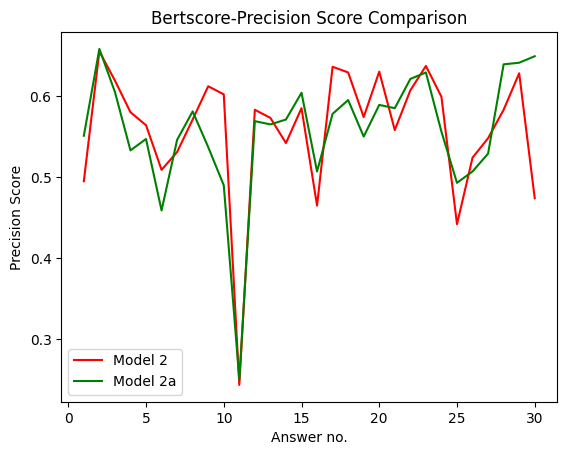

In [85]:
# plt.plot(index_list, m1_precision, label='Model 1', color='blue')
# plt.plot(index_list, m1a_precision, label='Model 1a', color='orange')
plt.plot(index_list, m2_precision, label='Model 2', color='red')
plt.plot(index_list, m2a_precision, label='Model 2a', color='green')

plt.title('Bertscore-Precision Score Comparison')
plt.legend()
plt.xlabel("Answer no.")
plt.ylabel("Precision Score")


plt.show()

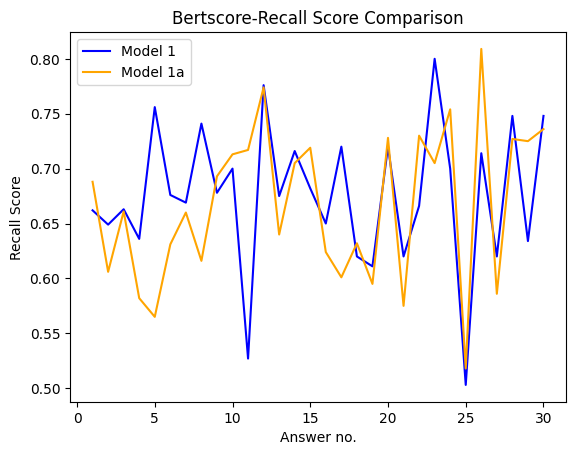

In [83]:
plt.plot(index_list, m1_recall, label='Model 1', color='blue')
plt.plot(index_list, m1a_recall, label='Model 1a', color='orange')
# plt.plot(index_list, m2_recall, label='Model 2', color='red')
# plt.plot(index_list, m2a_recall, label='Model 2a', color='green')

plt.title('Bertscore-Recall Score Comparison')

plt.legend()

plt.xlabel("Answer no.")
plt.ylabel("Recall Score")

plt.show()

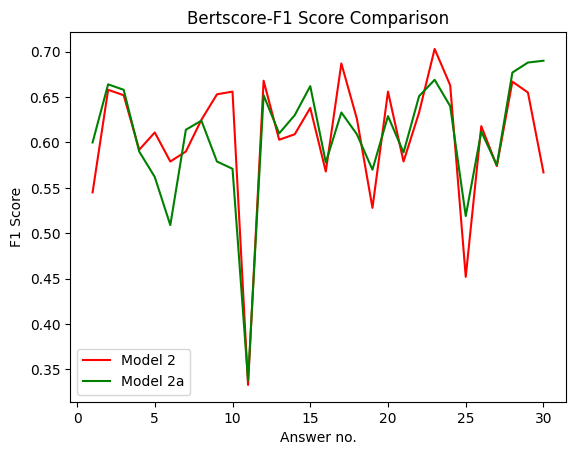

In [87]:
# plt.plot(index_list, m1_f1, label='Model 1', color='blue')
# plt.plot(index_list, m1a_f1, label='Model 1a', color='orange')
plt.plot(index_list, m2_f1, label='Model 2', color='red')
plt.plot(index_list, m2a_f1, label='Model 2a', color='green')

plt.title('Bertscore-F1 Score Comparison')

plt.legend()

plt.xlabel("Answer no.")
plt.ylabel("F1 Score")

plt.show()